In [1]:
#
import torch
from torchvision.datasets import CelebA
from torchvision.transforms import Compose, CenterCrop, Resize, ToTensor
from pythae.data.datasets import BaseDataset

data_root = "data"   # or wherever you keep datasets

transform = Compose([
    CenterCrop(178),       # celeba original
    Resize((32, 32)),      # downsample to 32x32
    ToTensor(),            # [0,1], shape [3,32,32]
])

celeba_train = CelebA(
    root=data_root,
    split="train",
    download=True,
    transform=transform
)

print("Total CelebA train images:", len(celeba_train))

# ---- build a subset tensor ----
N_SUBSET = 10_000  # adjust if this is too heavy
N_SUBSET = min(N_SUBSET, len(celeba_train))

xs = []
for i in range(N_SUBSET):
    img, _ = celeba_train[i]   # img: [3,32,32]
    xs.append(img)
x_celeba = torch.stack(xs, dim=0)  # [N,3,32,32]

print("x_celeba:", x_celeba.shape, x_celeba.dtype,
      x_celeba.min().item(), x_celeba.max().item())

# dummy labels (we don't care for unsupervised)
dummy_labels = torch.zeros(N_SUBSET, dtype=torch.long)

celeba_dataset = BaseDataset(
    data=x_celeba,
    labels=dummy_labels
)

print("BaseDataset len:", len(celeba_dataset))
print("One sample shape:", celeba_dataset[0].data.shape)

Total CelebA train images: 162770
x_celeba: torch.Size([10000, 3, 32, 32]) torch.float32 0.0 1.0
BaseDataset len: 10000
One sample shape: torch.Size([3, 32, 32])


In [10]:
# Define the model

from pythae.models import BetaVAE, BetaVAEConfig
from pythae.trainers import BaseTrainerConfig
from pythae.pipelines import TrainingPipeline

# conv benchmarks – try both import paths
try:
    from pythae.models.nn.cifar import Encoder_Conv_VAE_CIFAR, Decoder_Conv_AE_CIFAR
except ImportError:
    from pythae.models.nn.benchmarks.cifar import Encoder_Conv_VAE_CIFAR, Decoder_Conv_AE_CIFAR

latent_dim = 32  # start with 32; we can bump later

# ==========================
VAE_Beta = 8.0
# ==========================

beta_str = str(VAE_Beta).replace('.', '_')
betavae_celeba_config = BetaVAEConfig(
    input_dim=(3, 32, 32),
    latent_dim=latent_dim,
    reconstruction_loss="mse",  # natural images -> MSE is fine
    beta=VAE_Beta                    # plain VAE first
)

encoder_celeba = Encoder_Conv_VAE_CIFAR(betavae_celeba_config)
decoder_celeba = Decoder_Conv_AE_CIFAR(betavae_celeba_config)

betavae_celeba = BetaVAE(
    model_config=betavae_celeba_config,
    encoder=encoder_celeba,
    decoder=decoder_celeba,
)

print("Encoder:", betavae_celeba.encoder.__class__.__name__)
print("Decoder:", betavae_celeba.decoder.__class__.__name__)

Encoder: Encoder_Conv_VAE_CIFAR
Decoder: Decoder_Conv_AE_CIFAR


In [11]:
# Define training, add wandb, add nicer progress log. Start pipeline

import torch
from pythae.trainers.training_callbacks import WandbCallback

use_cuda = torch.cuda.is_available()
print("CUDA available:", use_cuda)

output_DIR = f"celeba_betavae_ld32_beta{beta_str}_mse"

print(f'Will save to {output_DIR}')
celeba_training_config = BaseTrainerConfig(
    output_dir = output_DIR,
    num_epochs=20,           # starting point
    learning_rate=1e-3,
    batch_size=128,
    steps_saving=1,
    no_cuda=not use_cuda
)


# Integrate with Wandb 
# Create callback list
callbacks = []
wandb_cb = WandbCallback()
wandb_cb.setup(
    training_config=celeba_training_config,   # your BaseTrainerConfig
    model_config=betavae_celeba.model_config, # BetaVAEConfig for this model
    project_name="MLSD_celeba_betavae"            # <- name it however you like
    #entity_name="akrotov",        # <- replace with your wandb username or org
)
callbacks.append(wandb_cb)

celeba_pipeline = TrainingPipeline(
    model=betavae_celeba,
    training_config=celeba_training_config,
)

celeba_pipeline(
    train_data=celeba_dataset,
    callbacks=callbacks
)

CUDA available: True
Will save to celeba_betavae_ld32_beta8_0_mse


Checking train dataset...
Using Base Trainer

! No eval dataset provided ! -> keeping best model on train.

Model passed sanity check !
Ready for training.

Created celeba_betavae_ld32_beta8_0_mse folder since did not exist.

Created celeba_betavae_ld32_beta8_0_mse/BetaVAE_training_2025-11-29_13-02-15. 
Training config, checkpoints and final model will be saved here.

Training params:
 - max_epochs: 20
 - per_device_train_batch_size: 64
 - per_device_eval_batch_size: 64
 - checkpoint saving every: 1
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Scheduler: None

Successfully launched training !



Training of epoch 1/20:   0%|          | 0/157 [00:00<?, ?batch/s]

Saved checkpoint at epoch 1

--------------------------------------------------------------------------
Train loss: 254.9659
--------------------------------------------------------------------------


Training of epoch 2/20:   0%|          | 0/157 [00:00<?, ?batch/s]

Saved checkpoint at epoch 2

--------------------------------------------------------------------------
Train loss: 94.7213
--------------------------------------------------------------------------


Training of epoch 3/20:   0%|          | 0/157 [00:00<?, ?batch/s]

Saved checkpoint at epoch 3

--------------------------------------------------------------------------
Train loss: 85.4192
--------------------------------------------------------------------------


Training of epoch 4/20:   0%|          | 0/157 [00:00<?, ?batch/s]

Saved checkpoint at epoch 4

--------------------------------------------------------------------------
Train loss: 83.8708
--------------------------------------------------------------------------


Training of epoch 5/20:   0%|          | 0/157 [00:00<?, ?batch/s]

Saved checkpoint at epoch 5

--------------------------------------------------------------------------
Train loss: 82.3956
--------------------------------------------------------------------------


Training of epoch 6/20:   0%|          | 0/157 [00:00<?, ?batch/s]

Saved checkpoint at epoch 6

--------------------------------------------------------------------------
Train loss: 81.9937
--------------------------------------------------------------------------


Training of epoch 7/20:   0%|          | 0/157 [00:00<?, ?batch/s]

Saved checkpoint at epoch 7

--------------------------------------------------------------------------
Train loss: 81.8034
--------------------------------------------------------------------------


Training of epoch 8/20:   0%|          | 0/157 [00:00<?, ?batch/s]

Saved checkpoint at epoch 8

--------------------------------------------------------------------------
Train loss: 80.9546
--------------------------------------------------------------------------


Training of epoch 9/20:   0%|          | 0/157 [00:00<?, ?batch/s]

Saved checkpoint at epoch 9

--------------------------------------------------------------------------
Train loss: 81.3363
--------------------------------------------------------------------------


Training of epoch 10/20:   0%|          | 0/157 [00:00<?, ?batch/s]

Saved checkpoint at epoch 10

--------------------------------------------------------------------------
Train loss: 81.1061
--------------------------------------------------------------------------


Training of epoch 11/20:   0%|          | 0/157 [00:00<?, ?batch/s]

Saved checkpoint at epoch 11

--------------------------------------------------------------------------
Train loss: 80.7544
--------------------------------------------------------------------------


Training of epoch 12/20:   0%|          | 0/157 [00:00<?, ?batch/s]

Saved checkpoint at epoch 12

--------------------------------------------------------------------------
Train loss: 80.3382
--------------------------------------------------------------------------


Training of epoch 13/20:   0%|          | 0/157 [00:00<?, ?batch/s]

Saved checkpoint at epoch 13

--------------------------------------------------------------------------
Train loss: 80.6429
--------------------------------------------------------------------------


Training of epoch 14/20:   0%|          | 0/157 [00:00<?, ?batch/s]

Saved checkpoint at epoch 14

--------------------------------------------------------------------------
Train loss: 80.6095
--------------------------------------------------------------------------


Training of epoch 15/20:   0%|          | 0/157 [00:00<?, ?batch/s]

Saved checkpoint at epoch 15

--------------------------------------------------------------------------
Train loss: 80.1226
--------------------------------------------------------------------------


Training of epoch 16/20:   0%|          | 0/157 [00:00<?, ?batch/s]

Saved checkpoint at epoch 16

--------------------------------------------------------------------------
Train loss: 80.1098
--------------------------------------------------------------------------


Training of epoch 17/20:   0%|          | 0/157 [00:00<?, ?batch/s]

Saved checkpoint at epoch 17

--------------------------------------------------------------------------
Train loss: 80.3619
--------------------------------------------------------------------------


Training of epoch 18/20:   0%|          | 0/157 [00:00<?, ?batch/s]

Saved checkpoint at epoch 18

--------------------------------------------------------------------------
Train loss: 79.3103
--------------------------------------------------------------------------


Training of epoch 19/20:   0%|          | 0/157 [00:00<?, ?batch/s]

Saved checkpoint at epoch 19

--------------------------------------------------------------------------
Train loss: 79.869
--------------------------------------------------------------------------


Training of epoch 20/20:   0%|          | 0/157 [00:00<?, ?batch/s]

Saved checkpoint at epoch 20

--------------------------------------------------------------------------
Train loss: 79.3153
--------------------------------------------------------------------------
Training ended!
Saved final model in celeba_betavae_ld32_beta8_0_mse/BetaVAE_training_2025-11-29_13-02-15/final_model


train/epoch_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/global_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train/epoch_loss,79.31534
train/global_step,20


Using device: cuda
Using training dir: celeba_betavae_ld32_beta1_0_mse/BetaVAE_training_2025-11-29_12-07-33
Loading checkpoint_epoch_1
Loading checkpoint_epoch_3
Loading final_model


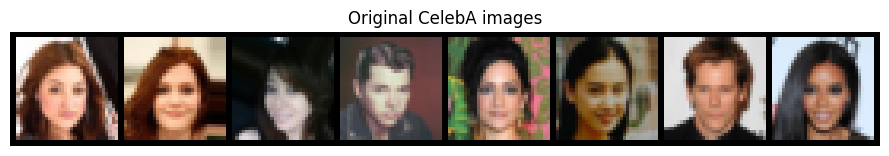

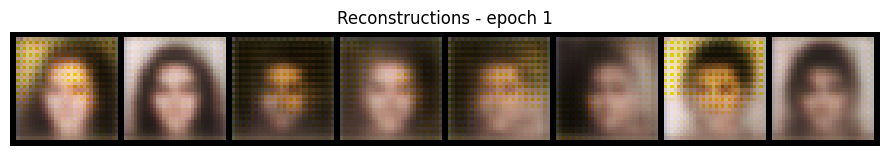

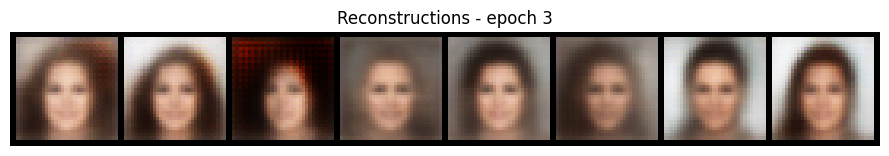

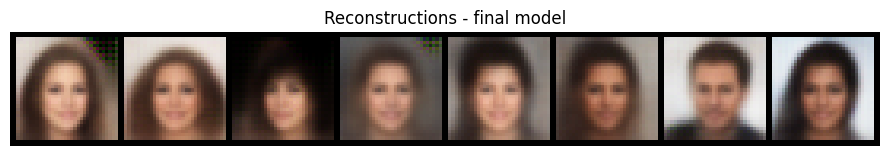

In [13]:
# Visualize one model's reconstruction and generation

import os, glob
import torch
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from torch.utils.data import DataLoader
from pythae.models import AutoModel

# ---------- device ----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ---------- config for this visualization ----------
#exp_dir = f"celeba_betavae_ld32_beta{beta_str}_mse"
exp_root = "celeba_betavae_ld32_beta1_0_mse"  # Custom beta???
epoch_ids = [1, 3]             # which checkpoints to show (if they exist)
gen_sigma = 1.0                # <---- configurable sigma for generation
gen_num_samples = 32           # how many samples to generate per checkpoint


training_runs = sorted(glob.glob(os.path.join(exp_root, "BetaVAE_training_*")))
assert training_runs, "No training_* folder found under output_dir"
training_dir = training_runs[-1]
print("Using training dir:", training_dir)

# ---------- which epochs to visualize ----------
epoch_ids = [1, 3]   # we will try all, skip missing
models = {}

for e in epoch_ids:
    ckpt_dir = os.path.join(training_dir, f"checkpoint_epoch_{e}")
    if os.path.isdir(ckpt_dir):
        print(f"Loading checkpoint_epoch_{e}")
        m = AutoModel.load_from_folder(ckpt_dir).to(device).eval()
        models[e] = m
    else:
        print(f"Skipping epoch {e}: {ckpt_dir} not found")

# also load final model for reference
final_dir = os.path.join(training_dir, "final_model")
if os.path.isdir(final_dir):
    print("Loading final_model")
    models["final"] = AutoModel.load_from_folder(final_dir).to(device).eval()

# ---------- helper: forward + get recon ----------
@torch.no_grad()
def get_recon(model, x):
    out = model({"data": x})
    if hasattr(out, "recon_x"):
        return out.recon_x
    elif hasattr(out, "reconstruction"):
        return out.reconstruction
    else:
        return out  # fallback

# ---------- helper: show grid ----------
def show_grid(imgs, title):
    grid = vutils.make_grid(imgs.detach().cpu(), nrow=8, padding=2)
    plt.figure(figsize=(9, 3))
    plt.imshow(grid.permute(1, 2, 0).numpy())
    plt.axis("off")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# ---------- visualize ----------

train_vis_loader = DataLoader(celeba_dataset, batch_size=8, shuffle=True)

batch = next(iter(train_vis_loader))
x_batch = batch.data.to(device)   # BaseDataset item has .data

show_grid(x_batch, "Original CelebA images")

for e in epoch_ids:
    if e in models:
        recon = get_recon(models[e], x_batch)
        show_grid(recon, f"Reconstructions - epoch {e}")

if "final" in models:
    recon_final = get_recon(models["final"], x_batch)
    show_grid(recon_final, "Reconstructions - final model")

Using device: cuda
Using training dir: celeba_betavae_ld32_beta0_5_mse/BetaVAE_training_2025-11-29_12-24-56
Loading checkpoint_epoch_1
Loading checkpoint_epoch_3
Loading final_model
Xbatch shape: torch.Size([8, 3, 32, 32])


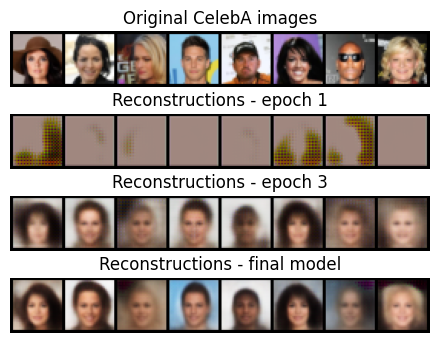

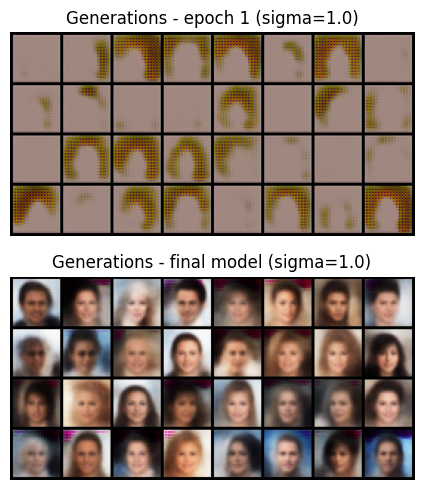

In [40]:
# Visualize one model's reconstruction and generation
#   Figure 1: originals + reconstructions
#   Figure 2: generations

import os, glob
import torch
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from torch.utils.data import DataLoader
from pythae.models import AutoModel

# ---------- device ----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ---------- config for this visualization ----------
#exp_dir = f"celeba_betavae_ld32_beta{beta_str}_mse"
exp_dir = "celeba_betavae_ld32_beta0_5_mse"  # Custom beta???
epoch_ids = [1, 3]             # which checkpoints to show (if they exist) for recon

gen_sigma = 1.0                # sigma for generation
gen_num_samples = 32           # how many samples to generate
gen_epoch_id = 1               # ONLY this epoch gets generation (in addition to final)

# ---------- locate latest training run ----------
training_runs = sorted(glob.glob(os.path.join(exp_dir, "BetaVAE_training_*")))
assert training_runs, "No training_* folder found under output_dir"
training_dir = training_runs[-1]
print("Using training dir:", training_dir)

models = {}

# load requested checkpoints
for e in epoch_ids:
    ckpt_dir = os.path.join(training_dir, f"checkpoint_epoch_{e}")
    if os.path.isdir(ckpt_dir):
        print(f"Loading checkpoint_epoch_{e}")
        m = AutoModel.load_from_folder(ckpt_dir).to(device).eval()
        models[e] = m
    else:
        print(f"Skipping epoch {e}: {ckpt_dir} not found")

# also load final model for reference
final_dir = os.path.join(training_dir, "final_model")
if os.path.isdir(final_dir):
    print("Loading final_model")
    models["final"] = AutoModel.load_from_folder(final_dir).to(device).eval()

# ---------- helpers ----------

@torch.no_grad()
def get_recon(model, x):
    out = model({"data": x})
    if hasattr(out, "recon_x"):
        return out.recon_x
    elif hasattr(out, "reconstruction"):
        return out.reconstruction
    else:
        return out  # fallback

@torch.no_grad()
def generate_from_latent(model, num_samples=32, sigma=1.0):
    """Sample z ~ N(0, sigma^2 I) and decode to images."""
    latent_dim = model.model_config.latent_dim
    z = sigma * torch.randn(num_samples, latent_dim, device=device)
    dec_out = model.decoder(z)
    x_gen = dec_out.reconstruction.clamp(0.0, 1.0).cpu()
    return x_gen

def make_grid_cpu(imgs, nrow=8):
    grid = vutils.make_grid(imgs.detach().cpu(), nrow=nrow, padding=2)
    return grid.permute(1, 2, 0).numpy()   # [H,W,C] for imshow

# ---------- get a batch of real images ----------
train_vis_loader = DataLoader(celeba_dataset, batch_size=8, shuffle=True)
batch = next(iter(train_vis_loader))
x_batch = batch.data.to(device)   # BaseDataset item has .data

# FIX THE BATCH.
@torch.no_grad()
def get_fixed_batch(batch_size=8, seed=123):
    #"""Return a fixed batch of images for evaluation."""
    torch.manual_seed(seed)
    batch_imgs = []

    for batch in train_vis_loader:
        # x: [B, C, H, W] in [0,1]
        x = batch.data
        batch_imgs.append(x)
        if len(torch.cat(batch_imgs, dim=0)) >= batch_size:
            break

    x_eval = torch.cat(batch_imgs, dim=0)[:batch_size].to(device)
    return x_eval

x_batch = get_fixed_batch(batch_size=8, seed=2025)
print(f'Xbatch shape: {x_batch.shape}')


# ---------- prepare recon + gen panels separately ----------

recon_panels = []
gen_panels = []

# originals + reconstructions
recon_panels.append(("Original CelebA images", make_grid_cpu(x_batch, nrow=8)))

for e in epoch_ids:
    if e in models:
        recon = get_recon(models[e], x_batch)
        recon_panels.append((f"Reconstructions - epoch {e}", make_grid_cpu(recon, nrow=8)))

if "final" in models:
    recon_final = get_recon(models["final"], x_batch)
    recon_panels.append(("Reconstructions - final model", make_grid_cpu(recon_final, nrow=8)))

# generations: only selected epoch + final
if gen_epoch_id in models:
    x_gen_epoch = generate_from_latent(
        models[gen_epoch_id],
        num_samples=gen_num_samples,
        sigma=gen_sigma,
    )
    gen_panels.append(
        (f"Generations - epoch {gen_epoch_id} (sigma={gen_sigma})",
         make_grid_cpu(x_gen_epoch, nrow=8))
    )

if "final" in models:
    x_gen_final = generate_from_latent(
        models["final"],
        num_samples=gen_num_samples,
        sigma=gen_sigma,
    )
    gen_panels.append(
        (f"Generations - final model (sigma={gen_sigma})",
         make_grid_cpu(x_gen_final, nrow=8))
    )

# ---------- Figure 1: reconstructions ----------
if recon_panels:
    n_recon = len(recon_panels)
    fig, axes = plt.subplots(n_recon, 1, figsize=(4.5, .9 * n_recon))
    if n_recon == 1:
        axes = [axes]

    for ax, (title, grid_img) in zip(axes, recon_panels):
        ax.imshow(grid_img)
        ax.axis("off")
        ax.set_title(title)

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.2)
    plt.show()

# ---------- Figure 2: generations ----------
if gen_panels:
    n_gen = len(gen_panels)
    fig, axes = plt.subplots(n_gen, 1, figsize=(9, 2.5 * n_gen))
    if n_gen == 1:
        axes = [axes]

    for ax, (title, grid_img) in zip(axes, gen_panels):
        ax.imshow(grid_img)
        ax.axis("off")
        ax.set_title(title)

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.2)
    plt.show()

Using device: cuda
Loading final model for β=0.5 from: celeba_betavae_ld32_beta0_5_mse/BetaVAE_training_2025-11-29_12-24-56/final_model
Loading final model for β=1.0 from: celeba_betavae_ld32_beta1_0_mse/BetaVAE_training_2025-11-29_12-07-33/final_model
Loading final model for β=8.0 from: celeba_betavae_ld32_beta8_0_mse/BetaVAE_training_2025-11-29_13-02-15/final_model
Batch shape: torch.Size([32, 3, 32, 32])


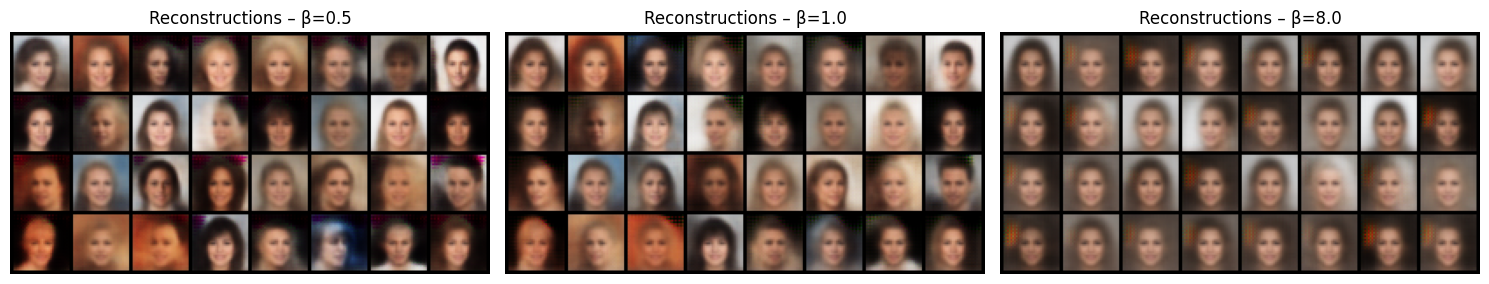

In [17]:
# Make that visualization for three betas
import os, glob
from pythae.models import AutoModel

# ---------- device ----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Map labels to experiment folders
exp_roots = {
    r"β=0.5": "celeba_betavae_ld32_beta0_5_mse",
    r"β=1.0": "celeba_betavae_ld32_beta1_0_mse",
    r"β=8.0": "celeba_betavae_ld32_beta8_0_mse",
}

models = {}

for label, exp_root in exp_roots.items():
    training_runs = sorted(glob.glob(os.path.join(exp_root, "BetaVAE_training_*")))
    assert training_runs, f"No training_* folder found under {exp_root}"
    training_dir = training_runs[-1]
    final_dir = os.path.join(training_dir, "final_model")
    assert os.path.isdir(final_dir), f"final_model not found in {training_dir}"

    print(f"Loading final model for {label} from: {final_dir}")
    m = AutoModel.load_from_folder(final_dir).to(device).eval()
    models[label] = m

@torch.no_grad()
def get_recon(model, x):
    out = model({"data": x})
    if hasattr(out, "recon_x"):
        return out.recon_x
    elif hasattr(out, "reconstruction"):
        return out.reconstruction
    else:
        return out  # fallback

from torch.utils.data import DataLoader

train_vis_loader = DataLoader(celeba_dataset, batch_size=32, shuffle=True)

batch = next(iter(train_vis_loader))
x_batch = batch.data.to(device)      # [32, 3, 32, 32]
print("Batch shape:", x_batch.shape)

import matplotlib.pyplot as plt
import torchvision.utils as vutils

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, (label, model) in zip(axes, models.items()):
    recon = get_recon(model, x_batch)                     # [32, 3, 32, 32]
    grid = vutils.make_grid(recon.detach().cpu(), nrow=8, padding=2)
    ax.imshow(grid.permute(1, 2, 0).numpy())
    ax.axis("off")
    ax.set_title(f"Reconstructions – {label}")

plt.tight_layout()
plt.show()

In [ ]:
# Sweep along first dimensions. Prepare the function

import torch
import torchvision.utils as vutils
import matplotlib.pyplot as plt

def traverse_latent_dim_local(model, x_single, dim, steps=9, delta=1.0):
    """
    Local traversal: vary z_dim in [z0_dim - delta, z0_dim + delta]
    """
    device = next(model.parameters()).device
    model.eval()

    x = x_single.unsqueeze(0).to(device)  # [1,3,32,32]

    with torch.no_grad():
        out = model({"data": x})
        z0 = out.z[0].detach()          # [latent_dim]

        zs = z0.repeat(steps, 1)        # [steps, latent_dim]
        vals = torch.linspace(
            z0[dim] - delta,
            z0[dim] + delta,
            steps,
            device=device,
        )
        zs[:, dim] = vals

        dec = model.decoder(zs)
        if hasattr(dec, "recon_x"):
            imgs = dec.recon_x
        elif hasattr(dec, "reconstruction"):
            imgs = dec.reconstruction
        else:
            imgs = dec

    return imgs  # [steps, 3, 32, 32]

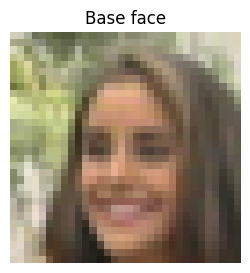

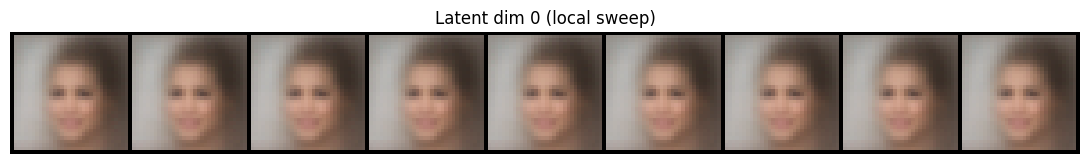

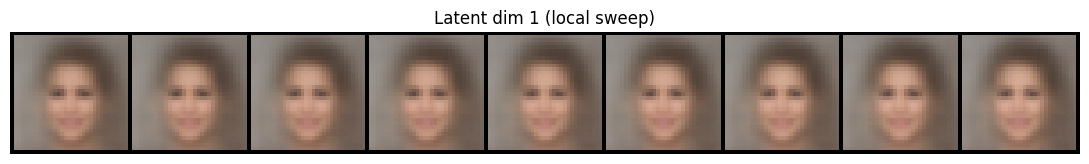

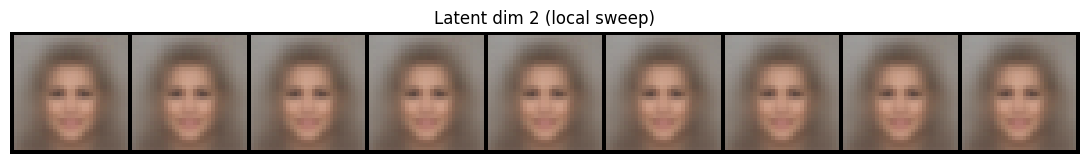

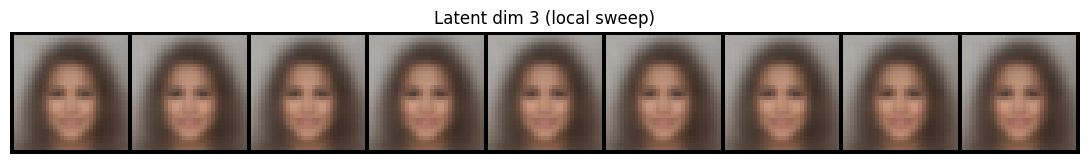

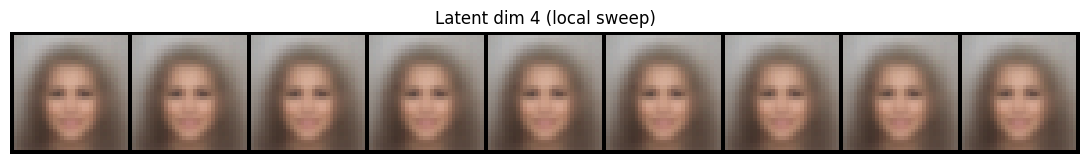

In [ ]:
# Sweep along first dimensions. Show the result 
# (Spoiler: nothing showed up really. Probably beta needs to be even higher - and encoder-decoder stronger)
from torch.utils.data import DataLoader

train_vis_loader = DataLoader(celeba_dataset, batch_size=1, shuffle=True)
batch = next(iter(train_vis_loader))
x_single = batch.data[0]  # [3,32,32]


#exp_dir = f"celeba_betavae_ld32_beta{beta_str}_mse"
exp_root = "celeba_betavae_ld32_beta8_0_mse"  # Custom beta???
training_runs = sorted(glob.glob(os.path.join(exp_root, "BetaVAE_training_*")))
assert training_runs, "No training_* folder found under output_dir"
training_dir = training_runs[-1]
final_dir = os.path.join(training_dir, "final_model")
model = AutoModel.load_from_folder(final_dir).to(device).eval()

plt.figure(figsize=(3,3))
plt.imshow(x_single.permute(1,2,0).numpy())
plt.axis("off")
plt.title("Base face")
plt.show()

dims_to_view = [0, 1, 2, 3, 4]
for d in dims_to_view:
    imgs = traverse_latent_dim_local(model, x_single, dim=d, steps=9, delta=1.0)
    grid = vutils.make_grid(imgs.cpu(), nrow=imgs.shape[0], padding=1)
    plt.figure(figsize=(11, 2))
    plt.imshow(grid.permute(1, 2, 0).numpy())
    plt.axis("off")
    plt.title(f"Latent dim {d} (local sweep)")
    plt.tight_layout()
    plt.show()

Loading β=0.5 from celeba_betavae_ld32_beta0_5_mse/BetaVAE_training_2025-11-29_12-24-56/final_model
Loading β=1.0 from celeba_betavae_ld32_beta1_0_mse/BetaVAE_training_2025-11-29_12-07-33/final_model
Loading β=8.0 from celeba_betavae_ld32_beta8_0_mse/BetaVAE_training_2025-11-29_13-02-15/final_model


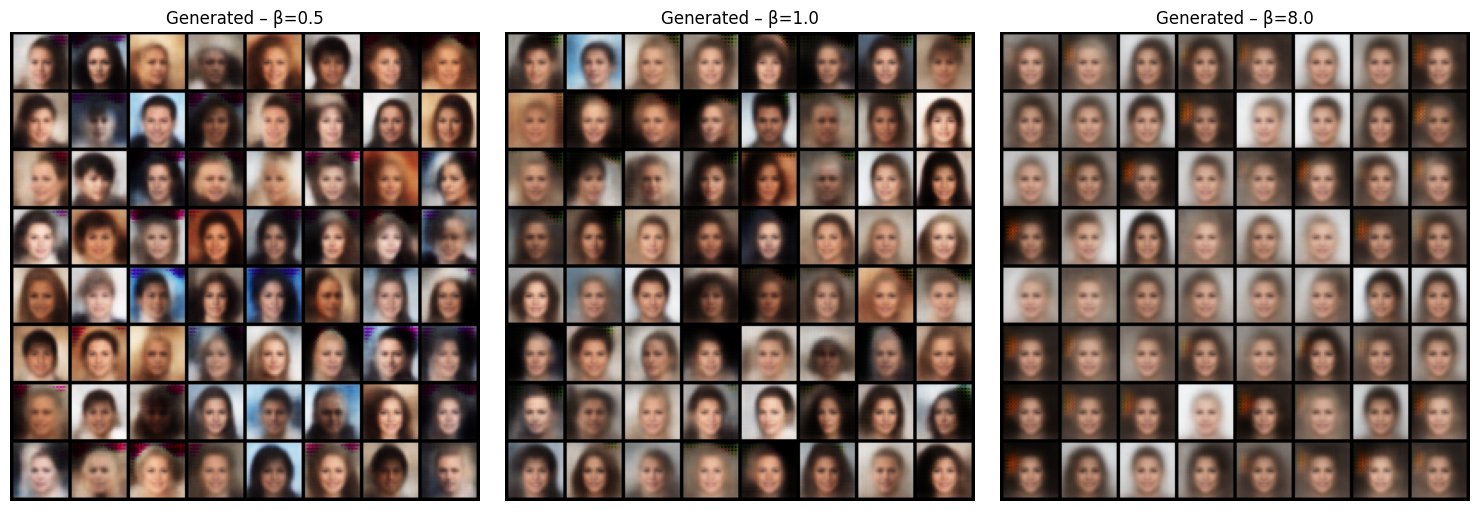

In [23]:
# Three betas side by side
import os, glob
import torch
from pythae.models import AutoModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Map beta labels to experiment directories
exp_roots = {
    r"β=0.5": "celeba_betavae_ld32_beta0_5_mse",
    r"β=1.0": "celeba_betavae_ld32_beta1_0_mse",
    r"β=8.0": "celeba_betavae_ld32_beta8_0_mse",
}

models = {}

for label, exp_root in exp_roots.items():
    runs = sorted(glob.glob(os.path.join(exp_root, "BetaVAE_training_*")))
    assert runs, f"Training folder not found: {exp_root}"
    training_dir = runs[-1]

    final_dir = os.path.join(training_dir, "final_model")
    print(f"Loading {label} from {final_dir}")
    m = AutoModel.load_from_folder(final_dir).to(device).eval()
    models[label] = m


import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

@torch.no_grad()
def generate_from_narrow_latent(model, num_samples=64, sigma=1.1):
    latent_dim = model.model_config.latent_dim
    z = sigma * torch.randn(num_samples, latent_dim, device=device)
    dec_out = model.decoder(z)
    x_gen = dec_out.reconstruction.clamp(0,1).cpu()
    return x_gen


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

num_samples = 64
sigma = 1.1

for ax, (label, model) in zip(axes, models.items()):
    x_gen = generate_from_narrow_latent(model, num_samples=num_samples, sigma=sigma)
    grid = make_grid(x_gen, nrow=8, padding=2)
    ax.imshow(grid.permute(1, 2, 0))
    ax.axis("off")
    ax.set_title(f"Generated – {label}")

plt.tight_layout()
plt.show()

In [24]:
# Fix evaluation batch to compute the metrics
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Use a loader you already have; pick one and stick with it
# loader = train_loader  # or val_loader
train_vis_loader = DataLoader(celeba_dataset, batch_size=8, shuffle=True)
loader = train_vis_loader

@torch.no_grad()
def get_fixed_batch(batch_size=64, seed=123):
    #"""Return a fixed batch of images for evaluation."""
    torch.manual_seed(seed)
    batch_imgs = []

    for batch in loader:
        # x: [B, C, H, W] in [0,1]
        x = batch.data
        batch_imgs.append(x)
        if len(torch.cat(batch_imgs, dim=0)) >= batch_size:
            break

    x_eval = torch.cat(batch_imgs, dim=0)[:batch_size].to(device)
    return x_eval

x_eval = get_fixed_batch(batch_size=64, seed=123)
x_eval.shape

torch.Size([64, 3, 32, 32])

In [ ]:
# Functions to compute the 7 metrics
import torch.nn.functional as F
import lpips
import piq

# Initialize LPIPS once (VGG backbone)
lpips_fn = lpips.LPIPS(net='vgg').to(device).eval()

@torch.no_grad()
def compute_recon_metrics_from_out(x, out, beta: float):
    """
    x:       [B, C, H, W] ground-truth images in [0,1]
    out:     model output with keys: recon_x, reg_loss, recon_loss, loss
    beta:    beta-VAE beta value (float)
    """
    x_hat = out.recon_x  # [B, C, H, W]

    # BCE: use Pythae's recon_loss if you used BCE as reconstruction_loss
    bce = out.recon_loss.mean().item()

    # MSE
    mse = F.mse_loss(x_hat, x, reduction="mean").item()

    # KL and ELBO
    if beta > 0:
        kl = (out.reg_loss / beta).mean().item()          # reg_loss = beta * KL
    else:
        kl = 0.0
    elbo = (out.recon_loss + out.reg_loss).mean().item()  # recon + beta*KL

    # Perceptual metrics expect 3 channels
    if x.shape[1] == 1:
        x_lp = x.repeat(1, 3, 1, 1)
        x_hat_lp = x_hat.repeat(1, 3, 1, 1)
    else:
        x_lp = x
        x_hat_lp = x_hat

    # LPIPS (average over batch)
    lp = lpips_fn(x_lp, x_hat_lp).mean().item()

    # SSIM, GMSD from piq (they *maximize* similarity; lower is worse)
    ssim_val = piq.ssim(x_hat, x, data_range=1.0).item()
    gmsd_val = piq.gmsd(x_hat, x, data_range=1.0).item()

    return {
        "BCE": bce,
        "MSE": mse,
        "KL": kl,
        "ELBO": elbo,
        "LPIPS": lp,
        "SSIM": ssim_val,
        "GMSD": gmsd_val,
    }

# GENERATED IMAGES

# Metrics for generated images
@torch.no_grad()
def eval_generation_self_recon_metrics(model, num_samples=64, beta: float = 4.0,
                                       sigma: float = 1.0, seed: int = 999):
    """
    1) Sample z ~ N(0, sigma^2 I)
    2) Decode z -> x_gen
    3) Pass x_gen back through the full model (encoder + decoder) to get x_gen_hat
    4) Compute same metrics between x_gen and x_gen_hat
    """
    torch.manual_seed(seed)
    model.eval()
    
    latent_dim = model.model_config.latent_dim

    # Step 1: sample z from prior (scaled by sigma if you want narrower)
    z = sigma * torch.randn(num_samples, latent_dim, device=device)

    # Step 2: decode
    dec_out = model.decoder(z)
    x_gen = dec_out.reconstruction.clamp(0.0, 1.0)

    # Step 3: pass generated images through encoder+decoder
    out_gen = model({"data": x_gen})
    
    # Step 4: metrics x_gen vs recon(x_gen)
    metrics_gen = compute_recon_metrics_from_out(x_gen, out_gen, beta=beta)
    return metrics_gen
    

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/home/alexalex/.pyenv/versions/benchmarkvae-39/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/alexalex/.pyenv/versions/benchmarkvae-39/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/alexalex/.pyenv/versions/benchmarkvae-39/lib/python3.9/site-packages/lpips/weights/v0.1/vgg.pth


In [ ]:
# Metrics for reconstrcuted images

exp_root = "celeba_betavae_ld32_beta1_0_mse"  # your output_dir

training_runs = sorted(glob.glob(os.path.join(exp_root, "BetaVAE_training_*")))
assert training_runs, "No training_* folder found under output_dir"
training_dir = training_runs[-1]
print("Using training dir:", training_dir)

final_dir = os.path.join(training_dir, "final_model")
model = AutoModel.load_from_folder(final_dir)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()  # inference mode


@torch.no_grad()
def eval_reconstruction_metrics(model, x_eval, beta: float):
    model.eval()
    out = model({"data": x_eval})  # Pythae expects dict input
    metrics = compute_recon_metrics_from_out(x_eval, out, beta=beta)
    return metrics


beta_value = 4.0  # MATCH THE FOLDER AT THE TOP OF THIS CELL!
recon_metrics = eval_reconstruction_metrics(model, x_eval, beta=beta_value)
gen_metrics = eval_generation_self_recon_metrics(
    model, num_samples=64, beta=beta_value, sigma=1.0, seed=999
)
#recon_metrics
print('=== RECONSTRUCTION ===')
print(recon_metrics)
print('=== GENERATION ===')
print(gen_metrics)

Using training dir: celeba_betavae_ld32_beta8_0_mse/BetaVAE_training_2025-11-29_13-02-15
=== RECONSTRUCTION ===
{'BCE': 62.38142395019531, 'MSE': 0.04061290621757507, 'KL': 0.5498570203781128, 'ELBO': 64.58084869384766, 'LPIPS': 0.42060986161231995, 'SSIM': 0.4303967356681824, 'GMSD': 0.23785550892353058}
=== GENERATION ===
{'BCE': 13.566948890686035, 'MSE': 0.008832650259137154, 'KL': 0.4594115912914276, 'ELBO': 15.404595375061035, 'LPIPS': 0.07196208834648132, 'SSIM': 0.8593510389328003, 'GMSD': 0.11472371220588684}
